In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss, auc, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform, randint

sns.set_theme()

In [107]:
data_name = 'n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv'
glathida_rgis = pd.read_csv(data_name, low_memory=False)
glathida_rgis = glathida_rgis.dropna()
df = glathida_rgis.drop(columns = 'RGIId')
df = df[df['THICKNESS'] != 0]

In [108]:
glacierTermTypes = ('Land-terminating', 'Marine-terminating', 'Lake-terminating',
                     'Dry calving', 'Regenerated', 'Shelf-terminating', 'Not assigned')
glacierID = (0, 1, 2, 3, 4, 5, 9)
classes = np.unique(df['TermType'])

for i in range(len(glacierTermTypes)):
    print(i, glacierTermTypes[i],': ', np.size(df[df['TermType'] == glacierID[i]]))

0 Land-terminating :  3090356
1 Marine-terminating :  621760
2 Lake-terminating :  24824
3 Dry calving :  0
4 Regenerated :  0
5 Shelf-terminating :  231594
6 Not assigned :  0


Only four of the TermTypes exists. Why are the other included?

In [109]:
def split(data, train_size, target):
    # Initial data split into x and y values.
    xData = pd.DataFrame(data)
    xData = xData.drop(columns = [target])
    # Target
    yData = data[target]

    # Split into test and training data
    xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, train_size = train_size, random_state = 42)

    return xTrain, xTest, yTrain, yTest

In [110]:
xTrain, xTest, yTrain, yTest = split(df, 0.8, 'TermType')

In [111]:
# Multi-layer Perceptron (MLP)
def ClassMLP_crude(xTrain, xTest, yTrain, yTest):
    # Define and train MLP classifier
    ClassifierMLP = MLPClassifier(random_state = 42, early_stopping=True)
    
    # Train the model on training data
    ClassifierMLP.fit(xTrain, yTrain)

    # Compute predictions from trained model:
    pre = ClassifierMLP.predict(xTest)
    acc = accuracy_score(yTest, pre)
    
    return acc, pre    

In [112]:
acc, pre = ClassMLP_crude(xTrain, xTest, yTrain, yTest)

print('Accuracy:')
print(acc)
print()
print('Clasification prediction:')
for i in range(len(glacierTermTypes)):
    print(i, glacierTermTypes[i], len(pre[np.where(pre == i)]))

Accuracy:
0.9649981731823164

Clasification prediction:
0 Land-terminating 10845
1 Marine-terminating 1963
2 Lake-terminating 73
3 Dry calving 0
4 Regenerated 0
5 Shelf-terminating 804
6 Not assigned 0


Hyperparameter optimization with grid search.

In [113]:
# Number of output neurons, Number of input neurons, Number of samples in training set, scaling factor in range 2-10.
def hiddenLayerSize(No, Ni, Ns, alpha): # Tries to estimate optimal hidden layer neurons.
    Nh = Ns / (alpha * (Ni + No))
    return Nh
No = 4

NhMax = int(hiddenLayerSize(4, np.shape(xTrain)[1], np.shape(xTrain)[0], 6))
NhMin = int(hiddenLayerSize(4, np.shape(xTrain)[1], np.shape(xTrain)[0], 10))
print(f'Hidden layer neuron range estimation: {NhMin} and {NhMax}')

hParamSpace = {'activation': ['relu', 'tanh'],
               'alpha': uniform(0.001, 0.1),
               'solver': ['adam', 'sgd'],
               'early_stopping': [True],
               'learning_rate': ['constant', 'adaptive'],
               'hidden_layer_sizes': [(randint(NhMin, NhMax).rvs(),
                                       randint(NhMin, NhMax).rvs(), 
                                       int(0.3 * randint(NhMin, NhMax).rvs()))]}

Hidden layer neuron range estimation: 89 and 149


In [114]:
def ClassMLPran(xTrain, xTest, yTrain, yTest, paramSpace, maxIts, crossValids):
    # Define the MLPClassifier.
    mlp = MLPClassifier(max_iter=maxIts, random_state=42)

    print("Data normalizing.")
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)
    xTest = scaler.transform(xTest)
    
    # Perform GridSearchCV
    print("Distribution search hyperparameter optimization.")
    grid_search = RandomizedSearchCV(estimator=mlp, param_distributions=paramSpace, cv=crossValids, n_jobs=-1)
    grid_search.fit(xTrain, yTrain)

    # Best parameters found during grid search.
    print("Best hyperparameters found.")
    best_params = grid_search.best_params_

    # Train MLPRegressor with best parameters.
    print("Training optimized model.")
    best_mlp = MLPClassifier(max_iter=maxIts, **best_params, random_state=42)
    best_mlp.fit(xTrain, yTrain)

    print("Finished model.")
    pre = best_mlp.predict(xTest)
    pre_prob = best_mlp.predict_proba(xTest)
    acc = accuracy_score(yTest, pre)
    loss = log_loss(yTest, pre_prob)

    return best_mlp, best_params, acc, pre, pre_prob, loss

bestMLP, bestParams, acc, pre, pre_prob, loss = ClassMLPran(xTrain, xTest, yTrain, yTest, hParamSpace, 20, 5)

Data normalizing.
Distribution search hyperparameter optimization.


C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Best hyperparameters found.
Training optimized model.
Finished model.


C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [115]:
print(f'Accuracy: {acc}')
print(f'Loss {loss}')
print()
print(f'Best parameters found:')
print(bestParams)

Accuracy: 0.9886006576543661
Loss 0.035664977785588935

Best parameters found:
{'activation': 'tanh', 'alpha': 0.08614337426217844, 'early_stopping': True, 'hidden_layer_sizes': (107, 89, 43), 'learning_rate': 'adaptive', 'solver': 'adam'}


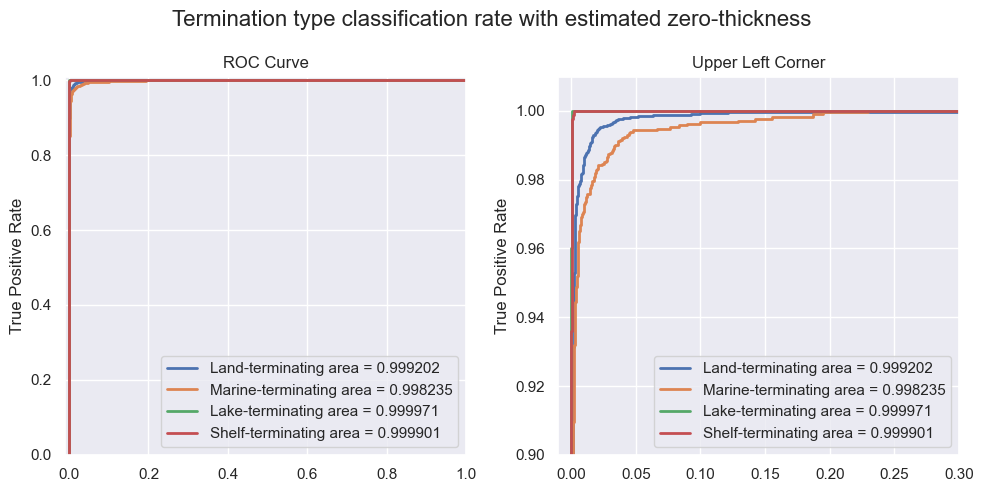

In [124]:
# Assuming your classes are already defined
n_classes = len(classes)
y_test_binarized = label_binarize(yTest, classes=classes)
y_score = pre_prob

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(n_classes):
    ax[0].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[int(classes[i])]} area = {roc_auc[i]:.6f}')

ax[0].set_xlim([-0.01, 1.0])
ax[0].set_ylim([0.0, 1.01])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend(loc='lower right')

for i in range(n_classes):
    ax[1].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[int(classes[i])]} area = {roc_auc[i]:.6f}')

ax[1].set_xlim([-0.01, 0.3])
ax[1].set_ylim([0.9, 1.01])
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Upper Left Corner')
ax[1].legend(loc='lower right')

fig.suptitle('Termination type classification rate with estimated zero-thickness', size = 16)

plt.tight_layout()
plt.savefig('roc_class_termtype_n0.png')
plt.show()


In [117]:
def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, prob=False):
    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    accuracy_difference = accuracy_train - accuracy_test
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Accuracy Difference: {accuracy_difference:.4f}")

test_overfitting(bestMLP, accuracy_score, xTrain, yTrain, xTest, yTest)

C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Training Accuracy: 0.3809
Test Accuracy: 0.3771
Accuracy Difference: 0.0039


C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
